# AI Brain tumor detection

## Imports

In [8]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn

## Data visualization

Visuliazation the dataset used. Plotting the number of images for each label considered

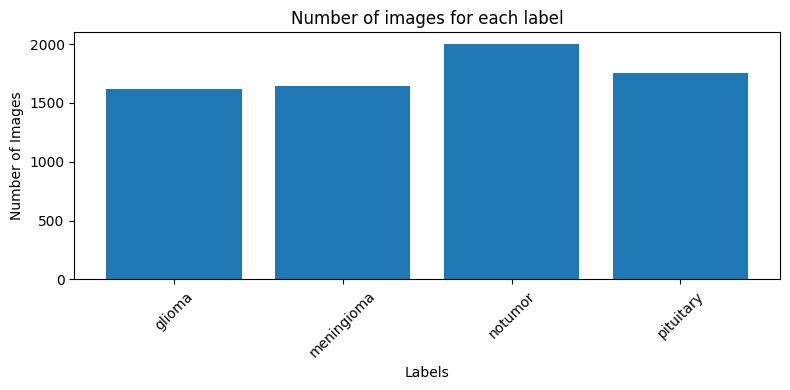

In [5]:
def load_image_count(directory_path):
    label_counts = defaultdict(int)
    
    for subdir in os.listdir(directory_path):
        subdir_path = os.path.join(directory_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    label_counts[subdir] += 1
    
    return label_counts

def plot_label_counts(label_counts):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title('Number of images for each label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dataset_directory = 'dataset/complete'
label_counts = load_image_count(dataset_directory)
plot_label_counts(label_counts)

## Data pre-processing

In [10]:
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

def process_images(path, labels):
    for label in labels:
        label_path = os.path.join(path, label)
        processed_path = os.path.join(label_path, f'processed_{label}')
        os.makedirs(processed_path, exist_ok=True)
        process_label(label_path, processed_path)

def process_label(label_path, processed_path):
    for img_name in os.listdir(label_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.img')):
            img_path = os.path.join(label_path, img_name)
            process_image(img_path, processed_path, img_name)

def process_image(img_path, processed_path, img_name):
    img = Image.open(img_path).convert('RGB')
    img_transformed = transform_pipeline(img)
    img_processed = transforms.ToPILImage()(img_transformed)
    img_processed.save(os.path.join(processed_path, img_name))

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
process_images('dataset/complete', labels)
print('Image has been cleaned. A new folder has been created for each label containing the processed images.')

Image has been cleaned. A new folder has been created for each label containing the processed images.


## Data splitting

Splitting cleaned dataset into 80% training and 20% testing

In [14]:
braintumors_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

dataset ='dataset/cleaned'

train_set = int(0.8 *len(dataset))
test_set = len(dataset) - train_set

torch.manual_seed(42)
train_set, test_set = random_split(dataset, [train_set,test_set])

#Set data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

12


## CNN model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolutional_layer = nn.Sequential(
            #First layer
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            

            #Second layer
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )

        self.fullyconnected_layer = nn.Sequential(
            #Fully connected layer
            nn.Dropout(p=0.1),
            nn.Flatten(),
            nn.Linear(32*64*64,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected_layer(x)
        return x